# Week 8: Gait Analysis???

<font size="6"> Laboratory 7 </font> <br>
<font size="3"> Last updated July 07, 2022 </font>

## <span style="color:orange;"> 00. Content </span>

<font size="5"> Mathematics </font>
- 3 dimensional vectors
- Integration
- Differentiation
    
<font size="5"> Programming Skills </font>
- Modules
    
<font size="5"> Embedded Systems </font>
- Thonny and MicroPython

## <span style="color:orange;"> 0. Required Content </span>
- Microcontroller: Raspberry Pi Pico
- Breadboard
- USB connector
- LSM9DS0 accelerometer
- OLED display
- TL1105 tactile switch
- 9-volt battery
- 7805 voltage regulator

<h3 style="background-color:lightblue"> Write your name and email below: </h3>

**Name:** me 

**Email:** me @purdue.edu

## Gait Analysis

Some common gait metrics used in a medical setting are step length, stride length, cadence, cycle time and joint angles. Some of these things we won't be able to measure with only an accelerometer but others are quite accessible like cadence, which is the number of steps per minute. In this lab, we will be analyzing the curvature and torsion of the path of the pedometer.

## Curvature

Curvature describes how sharply a smooth curve turns. For example, a straight line has zero curvature and a circle has constant curvature. If a smooth curve is parameterized by $\mathbf{r}(t) = \langle x(t),y(t),z(t) \rangle$, then the curvature $\kappa$ of $\mathbf{r}(t)$ at time $t$ is given by

$$\kappa(t) = \frac{||\mathbf{r}'(t) \times \mathbf{r}''(t)||}{||\mathbf{r}'(t)||^3}. $$

Before we calculate $\kappa$, it is important to note that if $\mathbf{r}(t)$ describes the path of the pedometer, then the acceleration values $\langle a_x(t),a_y(t),a_z(t) \rangle$ we obtain are not exactly $\mathbf{r}''(t)$ because the accelerometer is measuring acceleration due to gravity.

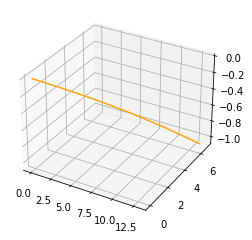

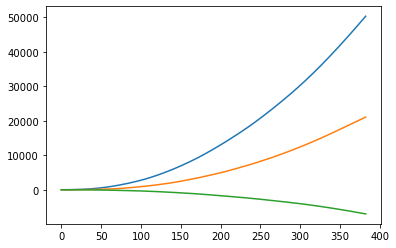

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import atan2

def anti_deriv(x,y):
    anti = y.copy()
    anti[0] = 0
    for i in range(1,len(y)):
        anti[i] = anti[i-1] + (x[i]-x[i-1])*y[i-1] # based on left riemann sum
    return anti

def adjust_accel(accel):
    adjusted = accel.copy()
    i=0
    for row in accel:
        [x,y,z] = row
        pitch = atan2(x, np.sqrt(y*y + z*z))
        roll = atan2(y, np.sqrt(x*x + z*z))
        theta = pitch   
        phi = roll
        R = np.array([[np.cos(theta),np.sin(theta)*np.sin(phi),np.cos(phi)*np.sin(theta)],
                    [0,np.cos(phi),-np.sin(phi)],
                    [-np.sin(theta),np.sin(phi)*np.cos(theta),np.cos(phi)*np.cos(theta)]])
        r = np.matmul(R,row) - np.array([0,0,1])
        adjusted[i] =  np.matmul(np.linalg.inv(R),r)
        i += 1
    return adjusted

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
accel = np.loadtxt('teststeps_big.txt', skiprows=50)
adjusted = adjust_accel(accel)
N = len(adjusted)
vel = adjusted.copy()
vel[:,0] = anti_deriv(np.arange(N), adjusted[:,0])
vel[:,1] = anti_deriv(np.arange(N), adjusted[:,1])
vel[:,2] = anti_deriv(np.arange(N), adjusted[:,2])
pos = vel.copy()
x = anti_deriv(np.arange(N), vel[:,0])
y = anti_deriv(np.arange(N), vel[:,1])
z = anti_deriv(np.arange(N), vel[:,2])

# ax.plot3D(accel[:,0], accel[:,1], accel[:,2], 'red')
ax.plot3D(x[:10],y[:10],z[:10], 'orange')
plt.show()

# plt.plot(adjusted[:,1])
# plt.plot(vel[:,1])
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.show()


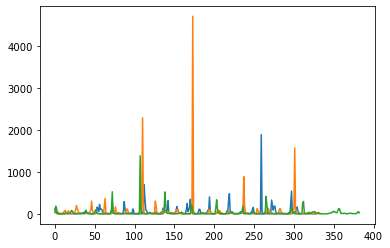

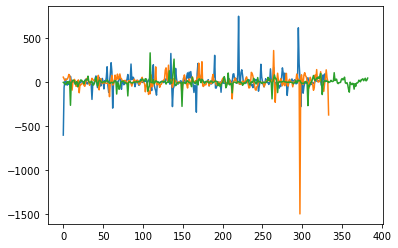

In [ ]:
from derivative import symmetric_difference


def anti_deriv3D(path):
    N = len(path)
    ans = path.copy()
    ans[:,0] = anti_deriv(np.arange(N), path[:,0])
    ans[:,1] = anti_deriv(np.arange(N), path[:,1])
    ans[:,2] = anti_deriv(np.arange(N), path[:,2])
    return ans

def curvature(file_name):
    r = np.loadtxt(file_name, skiprows=50)
    N = len(r)

    r_prime = r.copy()
    r_prime[:,0] = symmetric_difference(np.arange(N), r[:,0])
    r_prime[:,1] = symmetric_difference(np.arange(N), r[:,1])
    r_prime[:,2] = symmetric_difference(np.arange(N), r[:,2])

    r_2prime = r_prime.copy()
    r_2prime[:,0] = symmetric_difference(np.arange(N), r_prime[:,0])
    r_2prime[:,1] = symmetric_difference(np.arange(N), r_prime[:,1])
    r_2prime[:,2] = symmetric_difference(np.arange(N), r_prime[:,2])
    
    numer = np.linalg.norm(np.cross(r_prime,r_2prime) , axis=1)
    denom = np.linalg.norm(r_prime, axis=1) ** 3
    return numer/denom

def torsion(file_name):
    r = np.loadtxt(file_name, skiprows=50)
    N = len(r)

    r_prime = r.copy()
    r_prime[:,0] = symmetric_difference(np.arange(N), r[:,0])
    r_prime[:,1] = symmetric_difference(np.arange(N), r[:,1])
    r_prime[:,2] = symmetric_difference(np.arange(N), r[:,2])

    r_2prime = r_prime.copy()
    r_2prime[:,0] = symmetric_difference(np.arange(N), r_prime[:,0])
    r_2prime[:,1] = symmetric_difference(np.arange(N), r_prime[:,1])
    r_2prime[:,2] = symmetric_difference(np.arange(N), r_prime[:,2])

    r_3prime = r_2prime.copy()
    r_3prime[:,0] = symmetric_difference(np.arange(N), r_2prime[:,0])
    r_3prime[:,1] = symmetric_difference(np.arange(N), r_2prime[:,1])
    r_3prime[:,2] = symmetric_difference(np.arange(N), r_2prime[:,2])

    num = np.sum(np.cross(r_prime,r_2prime) * r_3prime, axis=1)
    den = np.linalg.norm(np.cross(r_prime,r_2prime) , axis=1) ** 2

    return num/den

plt.plot(curvature('test_accel.txt'))
plt.plot(curvature('teststeps_regular.txt'))
plt.plot(curvature('teststeps_big.txt'))
# plt.ylim((0,1000))
plt.show()

plt.plot(torsion('test_accel.txt'))
plt.plot(torsion('teststeps_regular.txt'))
plt.plot(torsion('teststeps_big.txt'))
# plt.ylim((-200,200))
plt.show()

__TODO:__ explain `anti_deriv` function with FTC

C:\Users\luzha\AppData\Local\Temp/ipykernel_11844/3651139775.py:49: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.arange(110,N),(numer/denom)[110:])


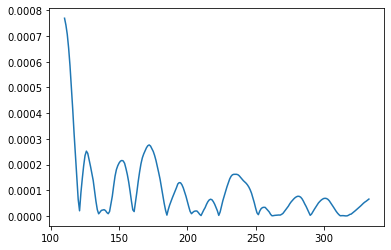

In [ ]:
from derivative import symmetric_difference
import numpy as np
import matplotlib.pyplot as plt

def anti_deriv(x,y):
    anti = y.copy()
    anti[0] = 0
    for i in range(1,len(y)):
        anti[i] = anti[i-1] + (x[i]-x[i-1])*y[i-1] # based on left riemann sum
    return anti

from math import atan2

accel = np.loadtxt('teststeps_regular.txt', skiprows=50)
adjusted = adjust_accel(accel)


# plt.plot(accel[:,0], label='ax(t)')
# plt.plot(accel[:,1], label='ay(t)')
# plt.plot(accel[:,2], label='az(t)')
# plt.plot(adjusted[:,0], label='aax(t)')
# plt.plot(adjusted[:,1], label='aay(t)')
# plt.plot(adjusted[:,2], label='aaz(t)')
# plt.legend()
# plt.show()

N = len(adjusted)
vel = adjusted.copy()
vel[:,0] = anti_deriv(np.arange(N), adjusted[:,0])
vel[:,1] = anti_deriv(np.arange(N), adjusted[:,1])
vel[:,2] = anti_deriv(np.arange(N), adjusted[:,2])

numer = np.linalg.norm(np.cross(vel,adjusted) , axis=1)
denom = np.linalg.norm(vel, axis=1) ** 3
# plt.plot(denom)
# plt.plot(np.linalg.norm(adjusted, axis=1))
plt.plot(np.arange(110,N),(numer/denom)[110:])
plt.show()


## Torsion 

The motion of a particle in space can be described by 3 vectors: the unit normal vector, the unit tangent vector, and the binormal vector, which is defined as the cross product between the unit tangent and unit normal vectors. Torsion describes the speed of rotation of the binormal vector.

If a smooth curve is parameterized by $\vec{r}(t) = \langle x(t),y(t),z(t) \rangle$, then the torsion $\kappa$ of $\vec{r}(t)$ at time $t$ is given by
$$ \tau(t) = \frac{(r'(t) \times r''(t))\cdot r'''(t)}{||r'(t) \times r''(t)||^2} $$

C:\Users\luzha\AppData\Local\Temp/ipykernel_10020/3310915750.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(num/den)


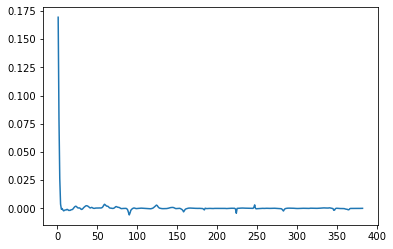

In [ ]:
jerk = accel.copy()
jerk[:,0] = symmetric_difference(np.arange(N), accel[:,0])
jerk[:,1] = symmetric_difference(np.arange(N), accel[:,1])
jerk[:,2] = symmetric_difference(np.arange(N), accel[:,2])

num = np.sum(np.cross(vel,accel) * jerk, axis=1)
den = numer ** 2

plt.plot(num/den)
plt.show()

### <span style="color:red"> Exercise </span>

- Take a look at these [racewalking techniques](https://www.verywellfit.com/how-to-racewalk-p2-3436286). How do some of the techniques listed relate to curvature and torsion?
- How could you change your gait to minimize/maximize changes in curvature over time? Describe and carry out a procedure to test your hypothesis.
- How could you change your gait to minimize/maximize changes in torsion over time? Describe and carry out a procedure to test your hypothesis.

<h3 style="background-color:lightblue"> Write Answers for Exercise Below </h3>

## <span style="color:green"> Reflection </span>

__1. What parts of the lab, if any, do you feel you did well? <br>
2. What are some things you learned today? <br>
3. Are there any topics that could use more clarification? <br>
4. Do you have any suggestions on parts of the lab to improve?__

<h3 style="background-color:lightblue"> Write Answers for the Reflection Below </h3>